# IA006 - Aprendizado de Máquina
## EFC 2 - Classificadores Lineares

### Alunos
* Daniel Rodrigues Silveira de Freitas - 145782
* João Carlos Cerqueira - 146611

## Parte 3 - Classificação multi-classe

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as op

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)

In [3]:
class LogReg():
    def __init__(self):
        pass

    def pred(self, X):
        try:
            return self.predict(self.fit_theta, X)
        except:
            print("Model is not trained yet")
    
    def prob(self, X):
        return self.probability(self.fit_theta, X)
    
    def predict(self, theta, X):
        s = self.probability(theta, X)
        return s > 0.5

    def probability(self, theta, X):
        return self.sigmoid(X @ theta)

    def sigmoid(self, z):
        return 1/(np.exp(-z) + 1)

    def cost_function(self, theta, X, y):
        m = y.shape[0]
        part1 = (-1 * y) @ np.log(self.sigmoid(X @ theta))
        part2 = (1 - y) @ np.log(1 - self.sigmoid(X @ theta))
        J = 1/m * (part1 - part2)
        return J

    def grad_function(self, theta, X, y):
        m = y.shape[0]
        grad = 1/m * (X.T @ (self.sigmoid(X @ theta) - y))
        return grad
    
    def fit(self, X, y, alpha=1, niter=10000, epsilon=0.001):
        theta = np.zeros(X.shape[1])
        
        for i in range(niter):
            grad = self.grad_function(theta, X, y)
            theta = theta - alpha * grad
            if np.sqrt((grad**2).sum()) < epsilon:
                break
            
        self.fit_theta = theta
        return self.fit_theta

In [4]:
class KnnClass():
    def __init__(self):
        pass
    
    def distance(self, X1, X2):
        return np.sqrt(((X1 - X2)**2).sum(axis=1))

    def fit(self, X, y, k):
        self.X_train = X
        self.y_train = y
        self.k = k
        
    def predict(self, X):
        d = np.zeros(X.shape[0])
        for i, line in enumerate(X):
            dist = self.distance(self.X_train, line)
            kn = self.y_train[dist.argsort()[:self.k]]
            
            label, counts = np.unique(kn, return_counts=True)
            d[i] = label[counts.argmax()]
            #print(dist, kn, label, counts, d[i])
        return d

In [5]:
def confmatrix(y_real, y_pred):
    conf = np.zeros([4,4])
    for target in range(4):
        for pred in range(4):
            conf[target, pred] = ((y_pred == pred) & (y_real == target)).sum()
    #print(conf)
    return conf

In [6]:
def precision(y_real, y_pred):
    pre = 0
    for c in range(4):
        tp = ((y_real == c) & (y_pred == c)).sum()
        fp = ((y_real != c) & (y_pred == c)).sum()
        pre += tp / (tp + fp)
    pre = pre/4
    return pre
    
def recall(y_real, y_pred):
    rec = 0
    for c in range(4):
        tp = ((y_real == c) & (y_pred == c)).sum()
        fn = ((y_real == c) & (y_pred != c)).sum()
        rec += tp / (tp + fn)
    rec = rec/4
    return rec
    
def f1score(y_real, y_pred):
    pre = precision(y_real, y_pred)
    rec = recall(y_real, y_pred)
    f1 = 2 * pre * rec / (pre + rec)    
    return f1

# Exploração inicial dos dados

Iremos carregar e analisar os dados disponíveis.

In [7]:
df = pd.read_csv("../data/dataset_vehicle.csv")
print(df.shape)
print(df['Class'].unique())
#print(df.describe())
df.head()

(846, 19)
['van' 'saab' 'bus' 'opel']


,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


#### Primeira análise
Nesse dataset existem 4 classes distintas: 'van', 'saab', 'bus' e 'opel'. Existem 18 colunas que serão utilizadas como *features* e uma última coluna, que é o label (o *groud truth* do problema). 

#### Normalização
Optou-se por realizar a normalização dos dados de entrada, para evitar-se problemas numéricos ao utilizar-se, por exemplo, o método do gradiente descendente aos dados do problema. Além disso, deve-se adicionar uma coluna de features que servirá como o *bias* do modelo, isto é, uma coluna de valores constantes.

#### Validação
Para validar os resultados sobre esse dataset empregou-se a validação por *holdout*. Separou-se os dados em 80% de observações de treino e 20% para teste. Além disso, o label foi codificado em valores entre 0 e 3, para facilitar a manipulação.

In [8]:
# Normalization, for numerical stability
for c in df.columns:
    if c != 'Class':
        df[c] = (df[c] - df[c].mean())/df[c].std()

# Adding column for bias
df['Bias'] = 1
df.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO,Class,Bias
0,0.160485,0.508649,0.057784,0.270646,1.306519,0.311358,-0.205723,0.136489,-0.224811,0.757884,-0.402146,-0.344731,0.285643,-0.328861,-0.076666,0.380766,-0.313537,0.183849,van,1
1,-0.325277,-0.625897,0.121190,-0.834750,-0.595044,0.094024,-0.596759,0.520535,-0.610593,-0.344374,-0.593260,-0.622048,-0.513214,-0.061731,0.533295,0.156833,0.010931,0.452709,van,1
2,1.253451,0.832805,1.516108,1.196788,0.545894,0.311358,1.147865,-1.143665,0.932534,0.688993,1.094916,1.104113,1.391753,0.071835,1.549895,-0.403000,-0.151303,0.049418,saab,1
3,-0.082396,-0.625897,-0.005621,-0.296990,0.165581,0.094024,-0.747158,0.648551,-0.610593,-0.344374,-0.911784,-0.740899,-1.465698,-1.263818,-0.076666,-0.291034,1.633267,1.528152,van,1
4,-1.053921,-0.139663,-0.766486,1.077286,5.236414,9.439378,-0.596759,0.520535,-0.610593,-0.275483,1.668259,-0.650346,0.408545,7.284361,0.533295,-0.179067,-1.449172,-1.698176,bus,1


In [9]:
# Spliting label and features
y = df['Class'].values
X = df.drop(columns=['Class']).values

# Encoding: van=0, saab=1, bus=2, opel=3
names = ['van', 'saab', 'bus', 'opel']
y_encoded = np.zeros(y.shape)
y_encoded += 0 * (y == 'van').astype(int)
y_encoded += 1 * (y == 'saab').astype(int)
y_encoded += 2 * (y == 'bus').astype(int)
y_encoded += 3 * (y == 'opel').astype(int)

# Spliting dataset into training and testing
train_test_split = 0.8
split = int(y.size * train_test_split)

y_train = y[:split]
X_train = X[:split]
y_enc_train = y_encoded[:split]

y_test = y[split:]
X_test = X[split:]
y_enc_test = y_encoded[split:]

In [10]:
print('Dados de teste:')
label, count = np.unique(y_train, return_counts=True)
for i, l in enumerate(label):
    print("Número de observações de {}: {}".format(l, count[i]))
print("")
print('Dados de teste:')
label, count = np.unique(y_test, return_counts=True)
for i, l in enumerate(label):
    print("Número de observações de {}: {}".format(l, count[i]))

Dados de teste:
Número de observações de bus: 173
Número de observações de opel: 175
Número de observações de saab: 169
Número de observações de van: 159

Dados de teste:
Número de observações de bus: 45
Número de observações de opel: 37
Número de observações de saab: 48
Número de observações de van: 40


#### Balanceamento de classes
Observa-se acima que as classes dentro dos conjuntos de teste e treino estão suficientemente balanceadas, i.e. não há grandes disparidades entre o número de ocorrências de cada classe, tanto no conjunto de treino quanto no conjunto de testes.

# Treinando a regressão logística multiclasse

Para se obter um classificador multiclasses baseado em regressão logística, escolheu-se o método de *one-vs-one*. Para isso, seis classificadores binários foram treinados. Como regra de desambiguação, implementou-se um sistema de votação, onde cada classificador realiza um voto e a classe com mais votos é a predição final. Finalmente, se houverem impates na votação, o critério final é escolher a classe de menor índice como valor predito; importante citar que existem formas de desambiguação mais elaboradas, mas que não serão exploradas neste trabalho.

A regressão logística é um exemplo de algoritmo de aprendizado de máquina que não possui fórmula analítica. Para obter os parâmetros do modelo, utilizou-se o algoritmo de otimização Gradiente Descendente (determinístico). O passo de otimização (alpha) foi de 1, e o critério de parada foi até que a norma euclidiana do vetor fosse menor que 10E-4, ou até o limite de 100.000 iterações.

In [11]:
def train_binary_class(X, y, class1, class2):
    # trains a binary classifier which predicts true for class1 and false for class2
    X_f = X[(y == class1) | (y == class2)]
    y_fs = y[(y == class1) | (y == class2)]
    y_f = (y_fs == class1)

    lr = LogReg()
    lr.fit(X_f, y_f, alpha=1, niter=100000, epsilon=0.0001)
    return lr

lr_van_saab = train_binary_class(X_train, y_train, 'van', 'saab')
lr_van_bus = train_binary_class(X_train, y_train, 'van', 'bus')
lr_van_opel = train_binary_class(X_train, y_train, 'van', 'opel')
lr_saab_bus = train_binary_class(X_train, y_train, 'saab', 'bus')
lr_saab_opel = train_binary_class(X_train, y_train, 'saab', 'opel')
lr_bus_opel = train_binary_class(X_train, y_train, 'bus', 'opel')

In [12]:
# Encoding: van=0, saab=1, bus=2, opel=3
y_reglog_pred = np.zeros(X_test.shape[0])

for i, line in enumerate(X_test):
    votes = np.zeros(4)
    
    if lr_van_saab.pred(line): votes[0] += 1
    else: votes[1] += 1
    
    if lr_van_bus.pred(line): votes[0] += 1
    else: votes[2] += 1
    
    if lr_van_opel.pred(line): votes[0] += 1
    else: votes[3] += 1
    
    if lr_saab_bus.pred(line): votes[1] += 1
    else: votes[2] += 1
        
    if lr_saab_opel.pred(line): votes[1] += 1
    else: votes[3] += 1
        
    if lr_bus_opel.pred(line): votes[2] += 1
    else: votes[3] += 1
        
    y_reglog_pred[i] = votes.argmax()

In [13]:
f1_reglog = f1score(y_enc_test, y_reglog_pred)
print("Para o algoritmo Regressão Logística, métrica F1-Score: {}".format(f1_reglog))

Para o algoritmo Regressão Logística, métrica F1-Score: 0.826658131491764


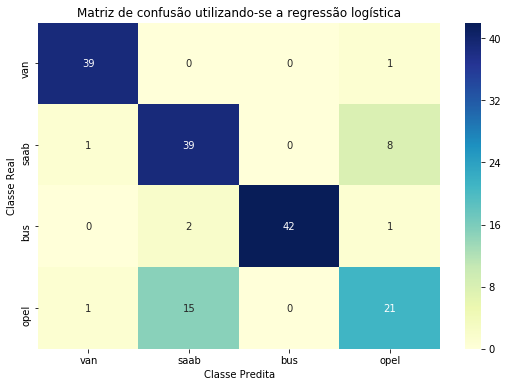

In [14]:
cm = confmatrix(y_enc_test, y_reglog_pred)
sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=names, yticklabels=names)
plt.ylabel("Classe Real")
plt.xlabel("Classe Predita")
plt.title("Matriz de confusão utilizando-se a regressão logística");

#### Resultados
Acima temos os resultados para o algoritmo de regressão logística. As métricas utilizadas para avaliar o algoritmo foram a matriz de confusão e o F1-Score (que foi utilizado como metrica global).

O F1-Score foi implementado utilizado-se as métricas precisão e recall. As métricas precisão e recall, por sua vez, foram implementadas usando médias macro, o que trata o desempenho individual para cada classe de forma equilibrada (i.e. a métrica é influenciada igualmente em relação à representativadade de cada classe).
A F1-Score é uma métrica que varia de 0 até 1. Para a regressão logística, obteve-se F1-Score igual a 0.8267, o que pode ser considerado um bom desempenho para o primeiro modelo treinado. 

#### Conclusão
A matriz de confusão é uma métrica que oferece informações interessantes a respeito do desempenho do algoritmo para as diferentes classes. A partir do resultado, temos que a principal deficiência do algoritmo foi na distinção das classes *saab* e *opel*. Temos que 15 observações do veículo *opel* foram erroneamente classificadas como *saab*, e 8 observações do veículo *saab* foram classificados como *opel*. Em relação as outras comparações, o algoritmo apresentou bom desempenho.

# Modelo de classificaçao k-NN
Nesta seção, obervou-se a performance do algoritmo k-NN para o mesmo conjunto de dados. Para a construção do modelo k-NN, a métrica de distância utilizada foi a euclidiana. Além disso, dentre os k vizinhos mais próximos, a todos os votos foram atribuídos o mesmo peso (i.e. utilizou-se pesos uniformes para as *k* observações). Uma alternativa a essa implementação seria, e.g., atribuir pesos proporcionais à distância da *k*-ésima observação ao seu voto. Além disso, é necessário decidir o valor de *k*, que é um hiperparâmetro do modelo.

In [15]:
def assess_knn_perf(max_k):
    for k in range(1, max_k):
        knn = KnnClass()
        knn.fit(X_train, y_enc_train, k)
        y_knn_pred = knn.predict(X_test)
        f1 = f1score(y_enc_test, y_knn_pred)
        print("Para k = {}, métrica F1-Score: {}".format(k, f1))
assess_knn_perf(30)

Para k = 1, métrica F1-Score: 0.6890392332426578
Para k = 2, métrica F1-Score: 0.7156935295006981
Para k = 3, métrica F1-Score: 0.7221756313124398
Para k = 4, métrica F1-Score: 0.7433234402110819
Para k = 5, métrica F1-Score: 0.7409368315320127
Para k = 6, métrica F1-Score: 0.7417772840685404
Para k = 7, métrica F1-Score: 0.7404782123684327
Para k = 8, métrica F1-Score: 0.7192737994931858
Para k = 9, métrica F1-Score: 0.7719475144261451
Para k = 10, métrica F1-Score: 0.77627811619244
Para k = 11, métrica F1-Score: 0.7751302114517039
Para k = 12, métrica F1-Score: 0.7609302809052725
Para k = 13, métrica F1-Score: 0.7638541995310497
Para k = 14, métrica F1-Score: 0.7467028469414422
Para k = 15, métrica F1-Score: 0.7296485401400684
Para k = 16, métrica F1-Score: 0.7296616178975545
Para k = 17, métrica F1-Score: 0.7576256213979832
Para k = 18, métrica F1-Score: 0.7543609702216031
Para k = 19, métrica F1-Score: 0.7717993602203472
Para k = 20, métrica F1-Score: 0.774028446408623
Para k = 21,

#### Escolhendo o hyperparâmetro k
Acima temos o desempenho do k-NN para diferentes valores de k. Dois valores escolhidos como de interesse são *k* igual a 10 e 20, pois ambos apresentaram altos valores de F1-Score. Iremos explorar mais a fundo o desempenho do modelo para esses dois valores de k.

In [16]:
def perf_confmatrix_knn(k):
    knn = KnnClass()
    knn.fit(X_train, y_enc_train, k)
    y_knn_pred = knn.predict(X_test)
    f1 = f1score(y_enc_test, y_knn_pred)
    print("Para k = {}, métrica F1-Score: {}".format(k, f1))
    
    cm = confmatrix(y_enc_test, y_knn_pred)
    sns.heatmap(cm, annot=True, cmap="YlGnBu", xticklabels=names, yticklabels=names)
    plt.ylabel("Classe Real")
    plt.xlabel("Classe Predita")
    plt.title("Matriz de Confusão do k-NN para k igual a " + str(k))

In [17]:
confmatrix(y_enc_test, y_reglog_pred)

array([[39.,  0.,  0.,  1.],
       [ 1., 39.,  0.,  8.],
       [ 0.,  2., 42.,  1.],
       [ 1., 15.,  0., 21.]])

Para k = 10, métrica F1-Score: 0.77627811619244


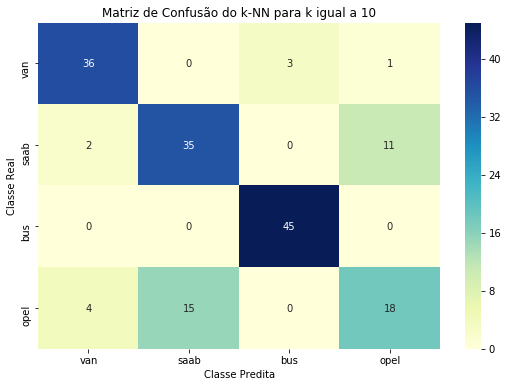

In [18]:
perf_confmatrix_knn(10)

Para k = 20, métrica F1-Score: 0.774028446408623


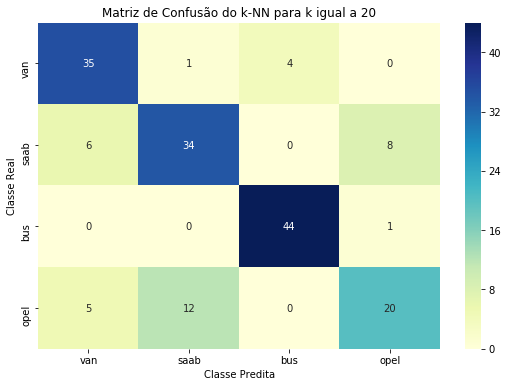

In [19]:
perf_confmatrix_knn(20)

As matrizes de confusão dos modelos com *k=10* e *k=20* foram bastante semelhantes. Da mesma forma que na regressão logística, as classes *opel* e *saab* apresentam o pior desempenho, quando comparadas às outras duplas de classes:
- Para k=10: temos que 15 observações do veículo *opel* foram erroneamente classificadas como *saab*, e 11 observações do veículo *saab* foram classificados como *opel*.
- Para k=20: temos que 12 observações do veículo *opel* foram erroneamente classificadas como *saab*, e 8 observações do veículo *saab* foram classificados como *opel*.
Para o restante das combinações dois-a-dois, o desempenho foi superior.

Conclui-se que os valores de hiperparâmetros selecionados apresentaram desempenho semelhantes.

Entretanto, ao comparar o desempenho do k-NN e da regressão logística, temos que o desempenho da desta é superior em relação ao F1-Score: 0.83 para a regressão logística contra 0.78 para o melhor k-NN obtido. Por exemplo, o k-NN apresentou erros consideráveis ao: classificar 6 observações do veículo *saab* como *van* e classificar 5 veículos *opel* como *van*; o algoritmo de regressão logística apresentou desempenho superior em ambas as situações.

Concluímos que, para este dataset, a regressão logística obteve um desempenho superior ao k-NN, em relação à métrica global escolhida.